In [3]:
import PIL
import numpy as np
import torch

from PIL import Image

from diffusers import StableDiffusionImg2ImgPipeline
from fastdownload import FastDownload
import torchvision.transforms.functional as TF

import ipywidgets as widgets
import matplotlib.pyplot as plt
import cv2 
%matplotlib inline

device, torch_dtype = "cpu", torch.float32

def preprocess(image):
    if isinstance(image, torch.Tensor):
        return image
    elif isinstance(image, Image.Image):
        image = [image]

    if isinstance(image[0], Image.Image):
        w, h = image[0].size
        w, h = map(lambda x: x - x % 8, (w, h))  # resize to integer multiple of 8

        image = [np.array(i.resize((w, h), resample=Image.Resampling.LANCZOS))[None, :] for i in image]
        image = np.concatenate(image, axis=0)
        image = np.array(image).astype(np.float32) / 255.0
        image = image.transpose(0, 3, 1, 2)
        image = 2.0 * image - 1.0
        image = torch.from_numpy(image)
    elif isinstance(image[0], torch.Tensor):
        image = torch.cat(image, dim=0)
    return image



In [4]:
pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "CompVis/stable-diffusion-v1-4",
    revision="fp16",
    torch_dtype=torch_dtype,
).to(device)

OSError: CompVis/stable-diffusion-v1-4 does not appear to have a file named model_index.json.

In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np

def image_grid(imgs, rows, cols):
    fig = plt.figure(figsize=(5*cols, 7*rows))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(cols, rows), 
                    axes_pad=0.5,  # pad between axes in inch.
                    )
    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes
        if isinstance(im, tuple):
            title, im = im
            ax.set_title(title)
        ax.imshow(im)

    plt.show()

def info(tens):
    return f"shape:{str(tuple(tens.shape)):>17}, min:{tens.min():>7.3f}, max:{tens.max():>7.3f}, mean:{tens.mean():>7.3f}, std:{tens.std():>7.3f}, var:{tens.var():>7.3f}, median:{np.median(tens):>7.3f}"

def tensor_to_rgb(tens):
    tens = (tens / 2 + 0.5).clamp(0, 1)
    tens = tens.cpu().permute(0, 2, 3, 1).float().numpy()
    return pipe.numpy_to_pil(tens)

def encode(x):
    x_half = x.to(dtype=torch_dtype, device=device)
    with torch.no_grad():
        latent = pipe.vae.encode(x_half).latent_dist.sample(None)
    return latent.cpu().float()

def decode(latent):
    latent_half = latent.to(dtype=torch_dtype, device=device)
    with torch.no_grad():
        x_hat = pipe.vae.decode(latent_half).sample
    return x_hat.cpu().float()

def norm(tens, color_scale=1, eps=1e-12):
    if tens.min() < 0:
        shift = -tens.min()
    else:
        shift = 0

    scale = (shift + tens.max()) / color_scale
    norm_tens = ((tens + shift)/scale) + eps
    return norm_tens, shift, scale

def un_norm(norm_tens, shift, scale):
    norm_tens = np.float32(norm_tens)
    tens = (norm_tens * scale) - shift
    return tens

def apply(tens, c, fun, mod = None, **kvargs):
    color_scale = kvargs.pop("color_scale", 1)
    norm_tens, *args = norm(tens[0, c, :], color_scale=color_scale)
    if mod != None:
        norm_tens = mod(norm_tens)
    tens[0, c, :] = un_norm(fun(norm_tens, **kvargs), *args)

def harmonize(t1, t2):
    t1[0, 0] = t2.max()
    t1[-1, -1] = t2.min()
    return t1

shape: (1, 3, 344, 936), min: -1.000, max:  1.000, mean: -0.118, std:  0.392, var:  0.154, median: -0.051
shape:  (1, 4, 43, 117), min:-43.594, max: 43.469, mean:  3.187, std:  4.141, var: 17.148, median:  3.926


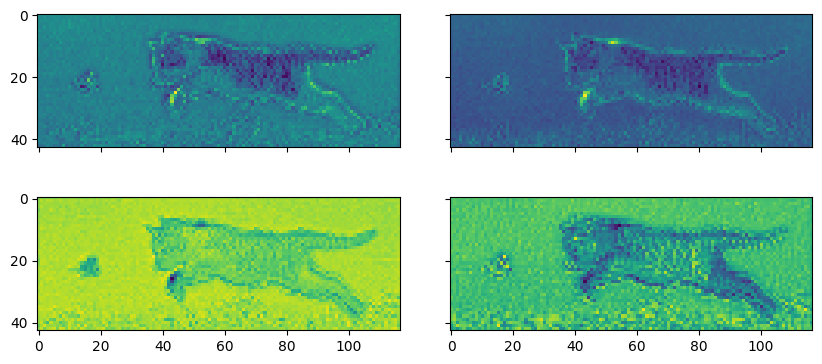

In [54]:
p = FastDownload().download('https://www.purina.com.tr/sites/default/files/2017-11/How-old-is-my-cat-in-human-years.jpg')
image = Image.open(p).convert("RGB")
image_tensor = preprocess(image)
print(info(image_tensor))
latent_tensor = encode(image_tensor)
print(info(latent_tensor))
image_grid(latent_tensor[0], rows=2, cols=2)


In [73]:
def add_noise(tens, beta=0.1):
    return tens*(1-beta) + torch.rand(size=tens.shape, dtype=tens.dtype, device=tens.device)*tens.max() *beta

def add_contrast(tens, sigma=1.3):
    mean = tens.mean()
    return (tens - mean)*sigma + mean

###########
# filters #
###########

def super_filter(tens, fun, *args, **kvargs):
    b, c, h, w = tens.shape
    tens = tens.numpy()
    for i in range(c):
        apply(tens, i, fun, *args, **kvargs)
    return torch.from_numpy(tens)

def filter_bilateral(tens, d, sigmaColor, sigmaSpace, color_scale):
    return super_filter(tens, cv2.bilateralFilter, d=d, sigmaColor=sigmaColor, sigmaSpace=sigmaSpace, color_scale=color_scale)

def filter_dilation(tens, kernel, iterations):
    return super_filter(tens, cv2.dilate, kernel=np.ones((kernel, kernel),np.uint8), iterations=iterations, color_scale=256, mod = lambda x: np.uint8(x))

def filter_edge(tens, threshold1, threshold2):
    return super_filter(tens, cv2.Canny, threshold1=threshold1, threshold2=threshold2, color_scale=256, mod = lambda x: np.uint8(x))

def filter_erode(tens, kernel, iterations):
    return super_filter(tens, cv2.erode, kernel=np.ones((kernel, kernel),np.uint8), iterations=iterations, color_scale=256, mod = lambda x: np.uint8(x))

def filter_gaussian(tens, kernel, color_scale, sigmaX, sigmaY):
    return super_filter(tens, cv2.GaussianBlur, ksize=(kernel,kernel), sigmaX=sigmaX, sigmaY=sigmaY, color_scale=color_scale)

def filter_laplacian(tens):
    return super_filter(tens, cv2.Laplacian, ddepth=cv2.CV_32F)

def filter_median(tens, kernel, color_scale):
    return super_filter(tens, cv2.medianBlur, ksize=kernel, color_scale=color_scale)

def filter_morphologyEx_closing(tens, kernel, iterations):
    return super_filter(tens, cv2.morphologyEx, op=cv2.MORPH_CLOSE, kernel=np.ones((kernel, kernel),np.uint8), iterations=iterations, color_scale=256, mod = lambda x: np.uint8(x))

def filter_morphologyEx_gradient(tens, kernel, iterations):
    return super_filter(tens, cv2.morphologyEx, op=cv2.MORPH_GRADIENT, kernel=np.ones((kernel, kernel),np.uint8), iterations=iterations, color_scale=256, mod = lambda x: np.uint8(x))

def filter_morphologyEx_opening(tens, kernel, iterations):
    return super_filter(tens, cv2.morphologyEx, op=cv2.MORPH_OPEN, kernel=np.ones((kernel, kernel),np.uint8), iterations=iterations, color_scale=256, mod = lambda x: np.uint8(x))

def filter_svd_reconstruction(tens, components, full_matrices):
    def svd_reconstruction(tens, components, full_matrices):
        u, s, v = np.linalg.svd(tens, full_matrices=full_matrices)
        var = s**2/np.sum(s**2)
        comps = int(len(s) * components)
        comps = components
        print(f"{sum(var[:comps])*100:.3f}% of information using {comps} of max {len(s)}")
        reconstruction = u[:, :comps] @ np.diag(s[:comps]) @ v[:comps, :]
        return reconstruction
    return super_filter(tens, svd_reconstruction, components=components, full_matrices=full_matrices)



########
# Lerp #
########
def super_lerp(tens, interpolate, fun, *args, **kvargs):
    ori = tens.clone()
    res = fun(tens, *args, **kvargs)
    return (1-interpolate)*ori + (interpolate)*res


def lerp_noise(tens, noise=0.1, interpolate=0):
    return super_lerp(tens, interpolate, add_noise, noise)

def lerp_contrast(tens, sigma=1.3, interpolate=0):
    return super_lerp(tens, interpolate, add_contrast, sigma)

def lerp_bilateral(tens, d, sigmaColor, sigmaSpace, color_scale, interpolate=0):
    return super_lerp(tens, interpolate, filter_bilateral, d, sigmaColor, sigmaSpace, color_scale)

def lerp_dilation(tens, kernel, iterations, interpolate=0):
    return super_lerp(tens, interpolate, filter_dilation, kernel, iterations)

def lerp_edge(tens, threshold1, threshold2, interpolate=0):
    return super_lerp(tens, interpolate, filter_edge, threshold1, threshold2)

def lerp_erode(tens, kernel, iterations, interpolate=0):
    return super_lerp(tens, interpolate, filter_erode, kernel, iterations)

def lerp_gaussian(tens, kernel, color_scale, sigmaX, sigmaY, interpolate=0):
    return super_lerp(tens, interpolate, filter_gaussian, kernel, color_scale, sigmaX, sigmaY)

def lerp_laplacian(tens, interpolate=0):
    return super_lerp(tens, interpolate, filter_laplacian)

def lerp_median(tens, kernel, color_scale, interpolate=0):
    return super_lerp(tens, interpolate, filter_median, kernel, color_scale)

def lerp_morphologyEx_closing(tens, kernel, iterations, interpolate=0):
    return super_lerp(tens, interpolate, filter_morphologyEx_closing, kernel, iterations)

def lerp_morphologyEx_gradient(tens, kernel, iterations, interpolate=0):
    return super_lerp(tens, interpolate, filter_morphologyEx_gradient, kernel, iterations)

def lerp_morphologyEx_opening(tens, kernel, iterations, interpolate=0):
    return super_lerp(tens, interpolate, filter_morphologyEx_opening, kernel, iterations)

def lerp_svd_reconstruction(tens, components, full_matrices, interpolate=0):
    return super_lerp(tens, interpolate, filter_svd_reconstruction, components, full_matrices)



In [84]:
interpolate_slide = widgets.FloatSlider(min=0., max=1.0, step=0.05, value=1.0, continuous_update=False)
svd_slide = widgets.IntSlider(min=1, max=43, step=1, value=1, continuous_update=False)
iterations_slide = widgets.IntSlider(min=1, max=10, step=1, value=1, continuous_update=False)
color_scale_slide = widgets.IntSlider(min=1, max=256, step=1, value=1, continuous_update=False)
conf = {
    "lerp_noise" : {"interpolate": interpolate_slide, "noise": (0., 1.)},
    "lerp_contrast" : {"interpolate": interpolate_slide, "sigma": (1., 3.)},
    "lerp_bilateral": {"interpolate": interpolate_slide, "d":(1, 17, 2), "sigmaColor":(1, 100), "sigmaSpace":(1,100), "color_scale": color_scale_slide}, 
    "lerp_dilation": {"interpolate": interpolate_slide,"kernel": (1, 10, 1), "iterations": iterations_slide},
    "lerp_edge": {"interpolate": interpolate_slide, "threshold1":(1, 100), "threshold2":(1, 100)}, 
    "lerp_erode": {"interpolate": interpolate_slide, "kernel": (1, 10, 1), "iterations": iterations_slide}, 
    "lerp_gaussian": {"interpolate": interpolate_slide, "kernel": (1, 17, 2), "color_scale": color_scale_slide, "sigmaX":(0., 1., 0.01),"sigmaY":(0., 1., 0.01)},
    "lerp_laplacian": {"interpolate": interpolate_slide}, 
    "lerp_median": {"interpolate": interpolate_slide, "kernel": (1, 5, 2), "color_scale": color_scale_slide},
    "lerp_morphologyEx_closing": {"interpolate": interpolate_slide, "kernel": (1, 10, 1), "iterations": iterations_slide},
    "lerp_morphologyEx_gradient": {"interpolate": interpolate_slide, "kernel": (1, 10, 1), "iterations": iterations_slide},
    "lerp_morphologyEx_opening": {"interpolate": interpolate_slide, "kernel": (1, 10, 1), "iterations": iterations_slide},
    "lerp_svd_reconstruction": {"interpolate": interpolate_slide, "components": svd_slide, "full_matrices": False},
}

def explore_latent(): 
    @widgets.interact(
            name=conf.keys())
    def selector(name):
        @widgets.interact(
            **conf[name])
        def plot(**kvargs):
            fun = globals()[name]
            print("transforming latent...")
            fun_latent_tensor = fun(latent_tensor.clone(), **kvargs)
            decoded_tensor = decode(fun_latent_tensor)
            print("transforming ref image...")
            lb, lc, lh, lw = latent_tensor.shape
            pb, pc, ph, pw = image_tensor.shape
            fun_small_tensor = TF.resize(fun(TF.resize(image_tensor.clone(), (lh, lw)), **kvargs), (ph, pw), TF.InterpolationMode.NEAREST)
            fun_tensor = fun(image_tensor.clone(), **kvargs)
            # diff = fun_tensor - decoded_tensor
            print("display...")
            image_grid([
                ("input", tensor_to_rgb(image_tensor)[0]), 
                ("decoded latent", tensor_to_rgb(decoded_tensor)[0]),
                ("transformed pixel",tensor_to_rgb(fun_tensor)[0]),
                ("downsampled transformed pixel",tensor_to_rgb(fun_small_tensor)[0]),
                ("latent", harmonize(TF.resize(torch.reshape(latent_tensor, (1, lh*lc, -1)), (ph*lc, pw), TF.InterpolationMode.NEAREST)[0], fun_latent_tensor)), 
                ("transformed latent", harmonize(TF.resize(torch.reshape(fun_latent_tensor, (1, lh*lc, -1)), (ph*lc, pw), TF.InterpolationMode.NEAREST)[0], latent_tensor)), 
                ], 2, 3)
    
            print("input             ", info(image_tensor))
            print("decoded latent    ", info(decoded_tensor))
            print("transformed pixel ", info(fun_tensor))
            print("downsampled pixel ", info(fun_small_tensor))
            print("latent            ", info(latent_tensor))
            print("transformed latent", info(fun_latent_tensor))
            



In [85]:
explore_latent()

interactive(children=(Dropdown(description='name', options=('lerp_noise', 'lerp_contrast', 'lerp_bilateral', '…